In [1]:
import os
import sys
import pandas as pd
from datetime import datetime, timedelta
import hashlib

In [2]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [3]:
import EncodeCommand

In [4]:
normal = pd.read_csv('../cleaned_data/normal.csv')
anomalous = pd.read_csv('../cleaned_data/anomalous0.csv')

In [5]:
normal.head()

,cwd,exit,items,ppid,pid,comm,timedelta,pid_timedelta,id_anomalies,num_id_anomalies
0,/,0.0,2.0,711.0,1943.0,pkla-check-auth,NaN,NaN,1.0,0
1,/,0.0,2.0,711.0,1948.0,pkla-check-auth,0.044,0 days 00:00:00.043999911,1.0,0
2,/var/lib/gdm,0.0,2.0,1324.0,1924.0,gsd-rfkill,-0.175,-1 days +23:59:59.825000047,1.0,0
3,/var/lib/gdm,0.0,2.0,1324.0,1916.0,gsd-sharing,-0.129,-1 days +23:59:59.871000051,1.0,0
4,/var/lib/gdm,0.0,2.0,1324.0,1922.0,gsd-keyboard,0.124,0 days 00:00:00.123999835,1.0,0


In [6]:
anomalous.head()

,cwd,exit,items,ppid,pid,comm,timedelta,pid_timedelta,id_anomalies,num_id_anomalies,ARGV_PROCTITLE_str
0,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,NaN,NaN,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
1,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
2,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
3,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
4,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...


## Preprocessing

In [7]:
normal.columns

Index(['cwd', 'exit', 'items', 'ppid', 'pid', 'comm', 'timedelta',
       'pid_timedelta', 'id_anomalies', 'num_id_anomalies'],
      dtype='object')

In [8]:
def count_directories(path):
    try:
        # Split the path into components
        components = path.split(os.sep)
        # Filter out empty components (which can occur if the path starts with a separator)
        directories = [comp for comp in components if comp]
    except:
        directories = []
    return len(directories)

In [9]:
def string_to_milliseconds(time_str):
    try:
        # Step 1: Parse the string into days and time component
        time_parts = time_str.split(' days ')
        days = int(time_parts[0])
        time_component = time_parts[1]
        
        # Step 2: Split the time component into hours, minutes, seconds, and microseconds
        hours, minutes, seconds = map(float, time_component.replace(':', ' ').split())
        
        # Step 3: Create a timedelta object
        time_delta = timedelta(
            days=days,
            hours=int(hours),
            minutes=int(minutes),
            seconds=int(seconds),
            microseconds=int((seconds - int(seconds)) * 1_000_000)
        )
        
        # Step 4: Convert the timedelta object to milliseconds
        milliseconds = time_delta.total_seconds() * 1000
    except:
        milliseconds = 0
    return abs(milliseconds)

In [10]:
def encode_pid_to_8bit_binary_hash(pid):
    """
    Encode a PID (Process ID) using SHA-256 hash and return an 8-bit binary string.

    Parameters:
    pid (int): The process ID to encode.

    Returns:
    str: An 8-bit binary representation of the hash of the PID.
    """
    # Convert the PID to a string and then to bytes
    pid_bytes = str(pid).encode('utf-8')
    
    # Compute the SHA-256 hash of the PID
    hash_object = hashlib.sha256(pid_bytes)
    
    # Get the hash as a hexadecimal string
    hash_hex = hash_object.hexdigest()
    
    # Convert the first byte (2 hex digits) of the hash to an integer
    first_byte = int(hash_hex[:2], 16)
    
    # Convert the integer to an 8-bit binary string
    binary_hash = format(first_byte, '08b')

    # final int
    r = int(binary_hash,2)
    
    return float(r/256)

In [11]:
def preprocess(df, encoder):
    
    # Select only common columns
    cols = ['cwd', 'exit', 'items', 'ppid', 'pid', 'comm', 'timedelta', 'pid_timedelta', 'id_anomalies', 'num_id_anomalies']
    df = df[cols]

    # convert times to numbers
    try:
        df['pid_timedelta_ms'] = df['pid_timedelta'].apply(string_to_milliseconds)
        df = df.drop('pid_timedelta', axis=1)
    except:
        pass
    
    # Fill NaN values with 0
    df = df.fillna(0)
    
    # preprocess cwd column by extracting path length
    df['fp_length'] = df['cwd'].apply(count_directories)
    df = df.drop('cwd', axis=1)

    # encode the command
    df = encoder.encode_command(df)
    df = df.drop('comm', axis=1)

    # encode the pids
    df['pid'] = df['pid'].apply(encode_pid_to_8bit_binary_hash)
    df['ppid'] = df['ppid'].apply(encode_pid_to_8bit_binary_hash)
    

    # convert all df to floats
    df = df.astype(float)
    
    return df
    

In [12]:
encoder = EncodeCommand.EncodeCommand()

In [13]:
n1 = preprocess(normal, encoder)
n1.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,pid_timedelta_ms,fp_length,enc_comm
0,0.0,2.0,0.503906,0.230469,0.000,1.0,0.0,0.000,0.0,1.0
1,0.0,2.0,0.503906,0.847656,0.044,1.0,0.0,43.999,0.0,1.0
2,0.0,2.0,0.988281,0.566406,-0.175,1.0,0.0,175.000,3.0,2.0
3,0.0,2.0,0.988281,0.132812,-0.129,1.0,0.0,129.000,3.0,3.0
4,0.0,2.0,0.988281,0.117188,0.124,1.0,0.0,123.999,3.0,4.0


In [14]:
a1 = preprocess(anomalous, encoder)
a1.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,pid_timedelta_ms,fp_length,enc_comm
0,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,5.0,1.0
1,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,5.0,1.0
2,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,5.0,1.0
3,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,5.0,1.0
4,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,5.0,1.0


## an det

In [15]:
import DeepLearningAnomalyDetection2

2024-09-01 08:23:18.175696: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 08:23:18.236930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 08:23:19.024243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Mean normal reconstruction error: 0.06679019179321731
Mean anomalous reconstruction error: 0.23629178625514077


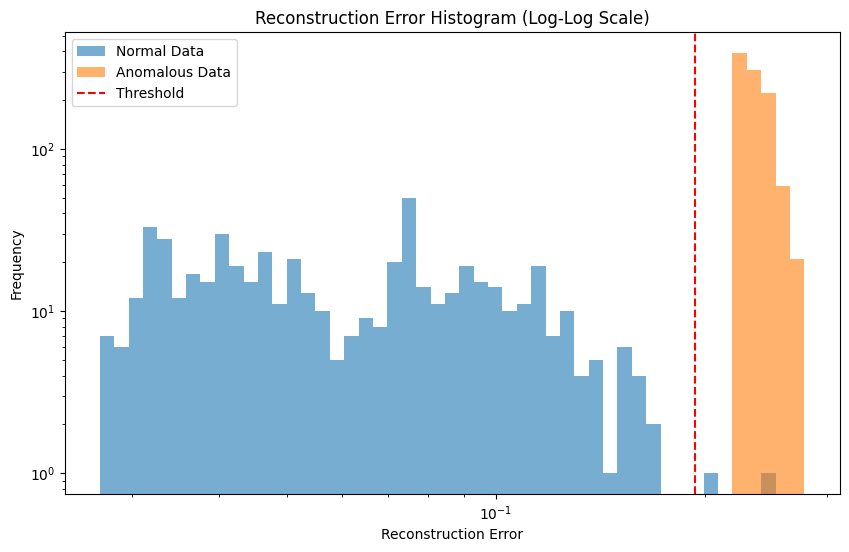

Threshold for anomaly detection: 0.19383968849555655
Number of anomalies detected: 1000
Number of false positives detected: 2


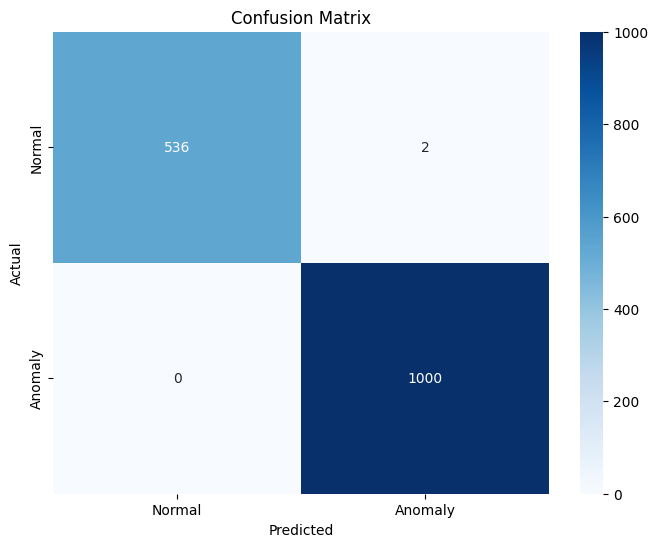

In [16]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(n1, a1, 'autoencoder', laurel=1, plots=[0,0,1,1])